In [3]:
!pip install scanpy
import os
import numpy as np
import pandas as pd
import scanpy as sc
import time
#
#more 10x datasets 
#https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/


#switch to keras for custom ae
#https://blog.keras.io/building-autoencoders-in-keras.html
#merging nerual networks
#https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split



In [4]:
from google.colab import drive
drive.mount('/content/drive')
#make a shortcut to emily's shared drive folder in your drive so you can access the data at
import os
os.listdir('/content/drive/My Drive/methyl_impute')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Peek_data.ipynb',
 'Project Proposal Brainstorming.gdoc',
 'adult_cortex_CG-CH_OLDCOPY.h5ad',
 'adult_cortex_CG_CH.h5ad',
 'PredictionModel.ipynb',
 'tf_multiclass_prediction.ipynb',
 'classifier_results.gslides',
 'Presentation.gslides',
 'VAE_impute (variational+loss).ipynb',
 'VAE_impute (variational).ipynb',
 'VAE_impute (vanilla) (custom dropout).ipynb',
 'ch_isImputed.parq',
 'cg_isImputed.parq',
 'VAE_impute (vanilla+tuned).ipynb',
 'Project_Report.gdoc',
 'vanilla tuning',
 'VAE_impute (vanilla) (custom dropout+loss).ipynb',
 'VAE_impute (variational+tuned).ipynb',
 'final_imputation_mask.parq',
 'VAE_tune']

In [5]:
adata=sc.read_h5ad('/content/drive/My Drive/methyl_impute/adult_cortex_CG_CH.h5ad')
adata

AnnData object with n_obs × n_vars = 11945 × 44772
    obs: 'sample', 'L1', 'L2', 'L3', 'true_batch', 'age', 'age_groups', 'leiden'
    var: 'batch'
    uns: 'L2_colors', 'L3_colors', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
#collect top marker genes

sc.tl.rank_genes_groups(adata, 'L3',n_genes=20)
# sc.pl.rank_genes_groups(adata, sharey=False)
markers=[]
for i in range(27):
    for j in range(20):
        if adata.uns['rank_genes_groups']['names'][j][i] not in markers:
            markers.append(adata.uns['rank_genes_groups']['names'][j][i])
"""adata2=adata[:,markers]
sc.pp.scale(adata2)
sc.pl.heatmap(adata2, markers, groupby='L3',vmax=1,vmin=-1)"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.7/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()

"adata2=adata[:,markers]\nsc.pp.scale(adata2)\nsc.pl.heatmap(adata2, markers, groupby='L3',vmax=1,vmin=-1)"

In [7]:
adata=adata[:,markers]
adata

View of AnnData object with n_obs × n_vars = 11945 × 351
    obs: 'sample', 'L1', 'L2', 'L3', 'true_batch', 'age', 'age_groups', 'leiden'
    var: 'batch'
    uns: 'L2_colors', 'L3_colors', 'leiden', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
##### read in matices for ch and cg
"""ch_impute_mask=pd.read_parquet('/content/drive/My Drive/methyl_impute/ch_isImputed.parq')
ch_new_cols = [x+"_CH" for x in ch_impute_mask.columns.values]
ch_impute_mask.columns=ch_new_cols
print(ch_impute_mask.shape)"""
#print(ch_impute_mask.head())

'ch_impute_mask=pd.read_parquet(\'/content/drive/My Drive/methyl_impute/ch_isImputed.parq\')\nch_new_cols = [x+"_CH" for x in ch_impute_mask.columns.values]\nch_impute_mask.columns=ch_new_cols\nprint(ch_impute_mask.shape)'

In [9]:
"""cg_impute_mask=pd.read_parquet('/content/drive/My Drive/methyl_impute/cg_isImputed.parq')
cg_new_cols = [x+"_CG" for x in cg_impute_mask.columns.values]
cg_impute_mask.columns=cg_new_cols
print(cg_impute_mask.shape)"""
#print(cg_impute_mask.head())

'cg_impute_mask=pd.read_parquet(\'/content/drive/My Drive/methyl_impute/cg_isImputed.parq\')\ncg_new_cols = [x+"_CG" for x in cg_impute_mask.columns.values]\ncg_impute_mask.columns=cg_new_cols\nprint(cg_impute_mask.shape)'

In [10]:
"""X_df = adata.to_df()
print(X_df.shape)"""
#print(X_df.head())

'X_df = adata.to_df()\nprint(X_df.shape)'

In [11]:
"""ch_col_overlap = np.intersect1d(X_df.columns.values, ch_impute_mask.columns.values)
ch_row_overlap = np.intersect1d(X_df.index.values, ch_impute_mask.index.values)
final_ch_impute_mask = ch_impute_mask.loc[ch_row_overlap, ch_col_overlap]
print(final_ch_impute_mask.shape)

cg_col_overlap = np.intersect1d(X_df.columns.values, cg_impute_mask.columns.values)
cg_row_overlap = np.intersect1d(X_df.index.values, cg_impute_mask.index.values)
final_cg_impute_mask = cg_impute_mask.loc[cg_row_overlap, cg_col_overlap]
print(final_cg_impute_mask.shape)

final_mask = pd.concat([final_ch_impute_mask, final_cg_impute_mask], axis=1)
final_mask = final_mask.reindex(X_df.index.values)
final_mask = final_mask.reindex(columns=X_df.columns.values)
final_mask = ~final_mask * 1
print(final_mask)"""

'ch_col_overlap = np.intersect1d(X_df.columns.values, ch_impute_mask.columns.values)\nch_row_overlap = np.intersect1d(X_df.index.values, ch_impute_mask.index.values)\nfinal_ch_impute_mask = ch_impute_mask.loc[ch_row_overlap, ch_col_overlap]\nprint(final_ch_impute_mask.shape)\n\ncg_col_overlap = np.intersect1d(X_df.columns.values, cg_impute_mask.columns.values)\ncg_row_overlap = np.intersect1d(X_df.index.values, cg_impute_mask.index.values)\nfinal_cg_impute_mask = cg_impute_mask.loc[cg_row_overlap, cg_col_overlap]\nprint(final_cg_impute_mask.shape)\n\nfinal_mask = pd.concat([final_ch_impute_mask, final_cg_impute_mask], axis=1)\nfinal_mask = final_mask.reindex(X_df.index.values)\nfinal_mask = final_mask.reindex(columns=X_df.columns.values)\nfinal_mask = ~final_mask * 1\nprint(final_mask)'

In [12]:
# print(final_mask.shape)

In [15]:
# (X_df.index == final_mask.index).all()

In [13]:
# final_mask.to_parquet('/content/drive/My Drive/methyl_impute/final_imputation_mask.parq')

In [8]:
final_mask = pd.read_parquet('/content/drive/My Drive/methyl_impute/final_imputation_mask.parq')

In [9]:
final_mask = final_mask[adata.to_df().columns.values].values

In [10]:
final_mask.shape

(11945, 351)

In [11]:
#data matrix, X
X=np.array(adata.X)
print(X.shape)
#cell type labels, y
yl=adata.obs['L3']
print(yl.shape)

(11945, 351)
(11945,)


In [12]:
print(X.shape[1])

351


In [13]:
class DropoutWithInference(layers.Layer):
    def __init__(self, rate, **kwargs):
        super(DropoutWithInference, self).__init__(**kwargs)
        self.rate = rate

    def _mask(self, args):
        methyl, boolean_imput = args
        methyl *= boolean_imput
        return methyl

    def call(self, inputs, training=None):
        methyl, boolean_impute = inputs
        if training:
            return layers.Dropout(rate=self.rate)(methyl)
        else:
            return layers.Lambda(self._mask)(inputs)

In [42]:
class VanillaAE:
  def __init__(self, input_shape,batch_size=256,optimizer=keras.optimizers.Adam(learning_rate=.001),epochs=50,
               loss_function=tf.keras.losses.MeanSquaredError(),callback=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)):
    self.input_shape=input_shape
    self.batch_size=batch_size
    self.n_epochs=epochs
    self.optimizer=optimizer
    self.loss_function=loss_function
    self.callback=callback
    self.model=self.generate_model_architecture()
    self.model.compile(optimizer=optimizer,loss=loss_function)

  def generate_model_architecture(self):
    mC_input=keras.Input(shape=(self.input_shape,), name='mC_input')
    imputed_boolean_input = keras.Input(shape=(self.input_shape,), name='imput_mask_input')
    input_dropout=DropoutWithInference(0.25, name='custom_dropout')([mC_input, imputed_boolean_input])
    dense1=layers.Dense(128,activation='relu', name='dense1')(input_dropout)
    dropout1=layers.Dropout(0.25, name='dropout1')(dense1)
    dense2=layers.Dense(64,activation='relu', name='dense2')(dropout1)
    dropout2=layers.Dropout(0.25, name='dropout2')(dense2)
    latent=layers.Dense(32,activation='relu', name='latent')(dropout2)
    out_pred=layers.Dense(self.input_shape,activation='linear',name='out_pred')(latent)

    return Model([mC_input, imputed_boolean_input],out_pred)

  def custom_loss(self, label_true, prediction, mask):
    squared_error = tf.math.square(tf.math.subtract(tf.cast(label_true, tf.float64), tf.cast(prediction, tf.float64)))
    masked_error = tf.math.multiply(squared_error, mask)
    return tf.math.reduce_mean(masked_error)

  def train_vae(self,train_dataset_vals, train_dataset_mask, test_dataset_vals, test_dataset_mask):
    """train_acc_metric = keras.metrics.MeanSquaredError()
    test_acc_metric = keras.metrics.MeanSquaredError()"""
    
    epochs = self.n_epochs
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        epoch_train_losses = []

        # Iterate over the batches of the dataset.
        for (step, (x_batch_train_vals)), (step, (x_batch_train_mask)) in zip(enumerate(train_dataset_vals), enumerate(train_dataset_mask)):
            with tf.GradientTape() as tape:
                logits = self.model([x_batch_train_vals, x_batch_train_mask], training=True)
                loss_value = self.custom_loss(x_batch_train_vals, logits, x_batch_train_mask)
            grads = tape.gradient(loss_value, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

            # Update training metric.
            # train_acc_metric.update_state(x_batch_train_vals, logits)
            epoch_train_losses.append(self.custom_loss(x_batch_train_vals, logits, x_batch_train_mask))

            # Log every 31 batches.
            if step % 31 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                #print("Seen so far: %d samples" % ((step + 1) * batch_size))

        # Display metrics at the end of each epoch.
        # train_acc = train_acc_metric.result()
        train_acc = sum(epoch_train_losses)/len(epoch_train_losses)
        print("Training acc over epoch: %.4f" % (float(train_acc),))
        # print('custom train loss: %.4f' % (float(sum(epoch_train_losses)/len(epoch_train_losses))))

        # Reset training metrics at the end of each epoch
        # train_acc_metric.reset_states()

        epoch_val_losses = []
        # Run a validation loop at the end of each epoch.
        for (x_batch_test_vals, x_batch_test_mask) in zip(test_dataset_vals, test_dataset_mask):
            test_logits = self.model([x_batch_test_vals, x_batch_test_mask], training=False)
            epoch_val_losses.append(self.custom_loss(x_batch_test_vals, test_logits, x_batch_test_mask))
            # Update val metrics
            # test_acc_metric.update_state(x_batch_test_vals, test_logits)
        # test_acc = test_acc_metric.result()
        # test_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(sum(epoch_val_losses)/len(epoch_val_losses)),))
        #print("Time taken: %.2fs" % (time.time() - start_time))"""

  def predict(self,X_vals,X_mask):
    return self.model.predict([X_vals, X_mask])

  def model_summary(self):
    self.model.summary()

  def visualize_model(self):
    #dunno how to make this show from the function lol
    keras.utils.plot_model(self.model, show_shapes=True, show_layer_names=True)



In [10]:
"""imputted_mask = np.random.randint(-5, 5, size=X.shape)
imputted_mask = np.where(imputted_mask <= 0, 0, imputted_mask)
imputted_mask = np.where(imputted_mask > 0, 1, imputted_mask)
print(imputted_mask)
print(imputted_mask.shape)"""

'imputted_mask = np.random.randint(-5, 5, size=X.shape)\nimputted_mask = np.where(imputted_mask <= 0, 0, imputted_mask)\nimputted_mask = np.where(imputted_mask > 0, 1, imputted_mask)\nprint(imputted_mask)\nprint(imputted_mask.shape)'

In [15]:
temp_input = np.concatenate([X, final_mask], axis=1)

X_train, X_test = train_test_split(temp_input, test_size=0.33, random_state=42,shuffle=True)
X_train_vals = X_train[:, :X.shape[1]]
X_train_mask = X_train[:, X.shape[1]:]
X_test_vals = X_test[:, :X.shape[1]]
X_test_mask = X_test[:, X.shape[1]:]
print(X_train_vals.shape)
print(X_test_vals.shape)
print(X_train_mask.shape)
print(X_test_mask.shape)

(8003, 351)
(3942, 351)
(8003, 351)
(3942, 351)


In [43]:
vae=VanillaAE(X.shape[1])

In [18]:
batch_size=256

"""train_dataset=tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=42).batch(batch_size)"""

train_dataset_vals=tf.data.Dataset.from_tensor_slices(X_train_vals)
train_dataset_vals = train_dataset_vals.shuffle(buffer_size=1024, seed=42).batch(batch_size)

train_dataset_mask=tf.data.Dataset.from_tensor_slices(X_train_mask)
train_dataset_mask = train_dataset_mask.shuffle(buffer_size=1024, seed=42).batch(batch_size)

"""test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(batch_size)"""

test_dataset_vals = tf.data.Dataset.from_tensor_slices(X_test_vals)
test_dataset_vals = test_dataset_vals.batch(batch_size)

test_dataset_mask = tf.data.Dataset.from_tensor_slices(X_test_mask)
test_dataset_mask = test_dataset_mask.batch(batch_size)

In [19]:
len(X_train)/batch_size

31.26171875

In [44]:
vae.train_vae(train_dataset_vals, train_dataset_mask, test_dataset_vals, test_dataset_mask)


Start of epoch 0
Training loss (for one batch) at step 0: 0.1599
Training loss (for one batch) at step 31: 0.0492
Training acc over epoch: 0.1017
Validation acc: 0.0348

Start of epoch 1
Training loss (for one batch) at step 0: 0.0448
Training loss (for one batch) at step 31: 0.0133
Training acc over epoch: 0.0228
Validation acc: 0.0069

Start of epoch 2
Training loss (for one batch) at step 0: 0.0126
Training loss (for one batch) at step 31: 0.0094
Training acc over epoch: 0.0107
Validation acc: 0.0077

Start of epoch 3
Training loss (for one batch) at step 0: 0.0101
Training loss (for one batch) at step 31: 0.0083
Training acc over epoch: 0.0090
Validation acc: 0.0087

Start of epoch 4
Training loss (for one batch) at step 0: 0.0085
Training loss (for one batch) at step 31: 0.0084
Training acc over epoch: 0.0080
Validation acc: 0.0095

Start of epoch 5
Training loss (for one batch) at step 0: 0.0078
Training loss (for one batch) at step 31: 0.0070
Training acc over epoch: 0.0074
Val

In [45]:
vae.predict(X_train_vals, X_train_mask)

array([[0.81277186, 0.8107872 , 0.7998881 , ..., 0.8023949 , 0.6569698 ,
        0.53736174],
       [0.5743839 , 0.26409596, 0.6951937 , ..., 0.69168395, 0.19973011,
        0.35959378],
       [0.8415467 , 0.8371217 , 0.7810413 , ..., 0.79696465, 0.6534292 ,
        0.47179103],
       ...,
       [0.68179137, 0.37291756, 0.7437143 , ..., 0.73908955, 0.21423824,
        0.437493  ],
       [0.67581093, 0.36383182, 0.7397619 , ..., 0.7349812 , 0.20897503,
        0.42891148],
       [0.77796465, 0.75207055, 0.82413346, ..., 0.81123453, 0.7002071 ,
        0.58444834]], dtype=float32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mC_input (InputLayer)          [(None, 351)]        0           []                               
                                                                                                  
 imput_mask_input (InputLayer)  [(None, 351)]        0           []                               
                                                                                                  
 custom_dropout (DropoutWithInf  (None, 351)         0           ['mC_input[0][0]',               
 erence)                                                          'imput_mask_input[0][0]']       
                                                                                                  
 dense1 (Dense)                 (None, 128)          45056       ['custom_dropout[0][0]']     

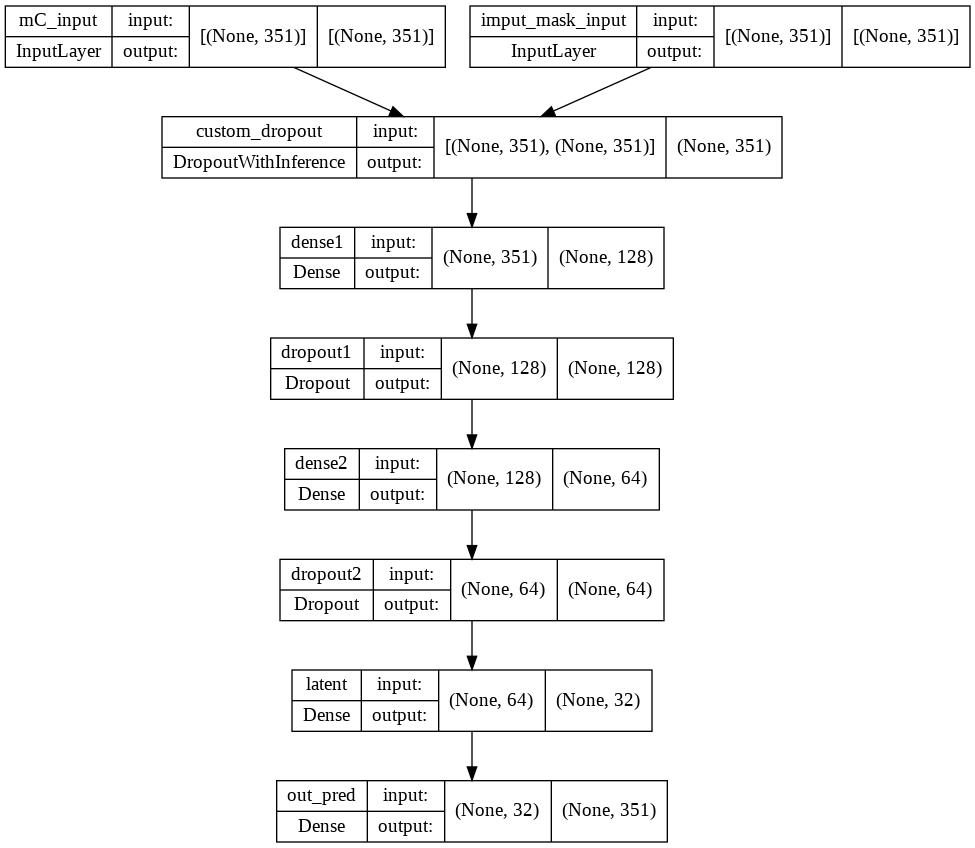

In [17]:
vae.model_summary()
#vae.visualize_model()
keras.utils.plot_model(vae.model, show_shapes=True, show_layer_names=True)